### Libraries

In [1]:
# Utils
import pandas as pd
import numpy as np
import json
import os
import subprocess
import zipfile
import IPython.display as ipd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

# Library for audio processing
import librosa
import soundfile as sf
from scipy.io.wavfile import write

# Data augmentation
from audiomentations import Compose, TimeStretch, PitchShift, Shift, Gain
import tensorflow as tf
import tensorflow_io as tfio
import cv2

# Visualizations and plots
import matplotlib.pyplot as plt

# Options
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

# Warnings
import warnings
warnings.filterwarnings('ignore', '.*PySoundFile failed. Trying audioread instead*.', )

c:\Users\Dinesh\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
audiotracks = pd.read_csv('public_dataset/metadata[FINAL].csv')
audiotracks = audiotracks.drop(['Unnamed: 0'], axis = 1)

In [3]:
audiotracks.groupby('COVID19_BI_2').size()

COVID19_BI_2
Negative    6397
Positive     468
dtype: int64

### Example

In [4]:
augment = Compose([
    TimeStretch(min_rate=0.75, max_rate=1.25, p=0.75),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.9),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.75),
    Gain(p=1)
])

In [5]:
audio_path = 'public_dataset/Example/audiopreprocessed_example.wav'
audio, sr = librosa.load(audio_path)
ipd.Audio(audio, rate = sr)

In [6]:
augmented_audio = augment(audio, sr)
sf.write('public_dataset/Example/augmented_example.wav', augmented_audio, 22050) # Saving the audio track
ipd.Audio(augmented_audio, rate = sr)

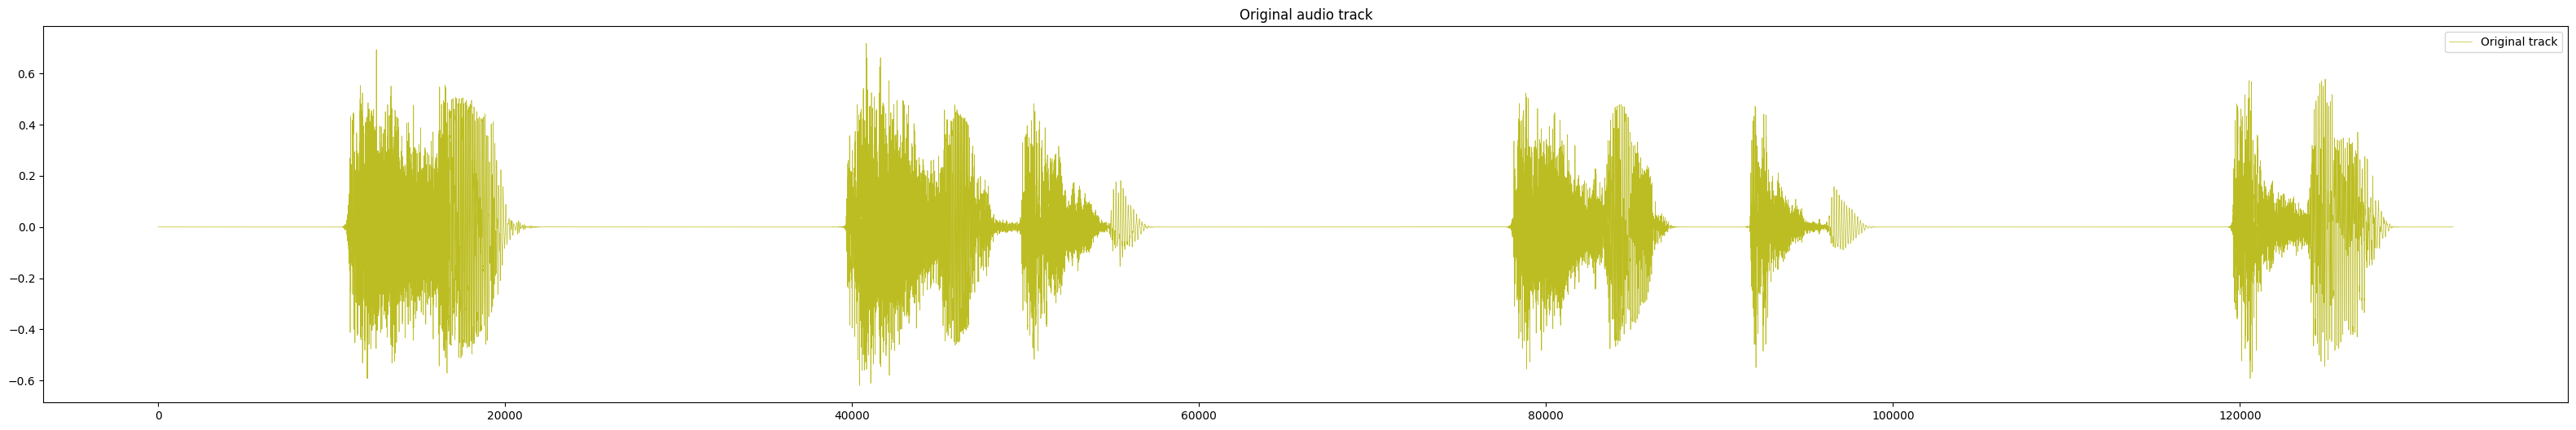

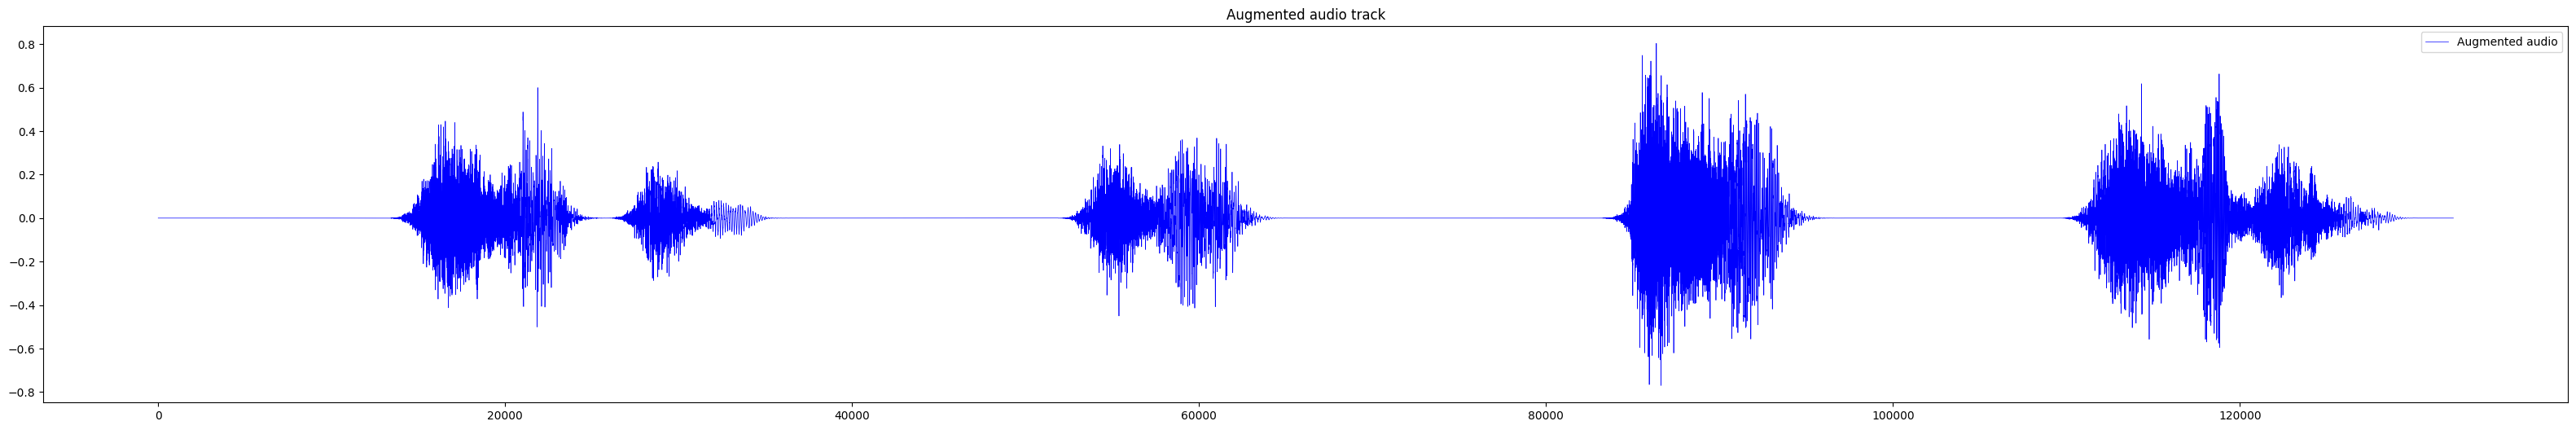

In [7]:
plt.figure(figsize=(40,6))
plt.plot(audio, color='tab:olive', linewidth=0.5, label = 'Original track')
# plt.hlines(0, 0, 5000,color='black', linewidth=0.7)
plt.title("Original audio track")
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(augmented_audio, color='blue', linewidth=0.5, label = 'Augmented audio')
# plt.hlines(0, 0, 5000, color='black', linewidth=0.7)
plt.title("Augmented audio track")
plt.legend()
plt.show()

### Data augmentation

As we continued working, we realized the problem that the classifier tends to effectively recognize only augmented audio. The ideal approach, however, is one in which augmentation is only applied to the training set, with the validation and test sets left unchanged and representative of the real data distribution. For this reason, we will both increase only the training set, to follow the ideal approach, and increase the entire dataset

In [8]:
# Split into train/test set
audiotracks_train, audiotracks_test = train_test_split(audiotracks, test_size=0.2, stratify=audiotracks["COVID19_BI_2"])

In [9]:
audiotracks_train.reset_index(inplace=True, drop=True)
audiotracks_test.reset_index(inplace=True, drop=True)

In [10]:
print(audiotracks_train.groupby('COVID19_BI_2').size())
print(audiotracks_test.groupby('COVID19_BI_2').size())

COVID19_BI_2
Negative    5118
Positive     374
dtype: int64
COVID19_BI_2
Negative    1279
Positive      94
dtype: int64


In [11]:
with open('public_dataset/AugAfterSplit/original_train.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  audiotracks_train.to_csv(f)

In [12]:
with open('public_dataset/AugAfterSplit/original_test.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  audiotracks_test.to_csv(f)

In this case, to reach the desired ratio, the augmentation is applied 5 times for each audio track of the minority class.

### Augmentation on full dataset

In [13]:
dataset_path = 'public_dataset/AudioNoNoise/'
write_path = 'public_dataset/AugAllDataset/'

In [14]:
def rawaudio_augmentation_BI2(audiotracks, audio_datadir, audio_writedir, indexes, aug_names):
  counter = 0
  for index, row in audiotracks.iterrows():
    if row['COVID19_BI_2'] == 'Positive':
      audioname = audio_datadir+row['uuid']
      tmp_audio, tmp_sr = librosa.load(audioname)

      i = 0
      # Performs augmentation x5
      while i < 5:
        writename = audio_writedir+'aug_'+str(i)+'_'+row['uuid']
        aug_names.append('aug_'+str(i)+'_'+row['uuid'])
        indexes.append(index)
        augmented_data = augment(tmp_audio, tmp_sr)
        write(writename, tmp_sr, augmented_data)

        i += 1
        
        counter += 1
        if counter%500==0:
          print('Augmentation counter: ' + str(counter))

In [15]:
indexes = []
aug_names = []
rawaudio_augmentation_BI2(audiotracks, dataset_path, write_path, indexes, aug_names)

Augmentation counter: 500
Augmentation counter: 1000
Augmentation counter: 1500
Augmentation counter: 2000


In [16]:
with open('public_dataset/FinalVersion/augmentation_index_fulldata.json', "w") as fp:
  json.dump(indexes, fp)

with open('public_dataset/FinalVersion/augmentation_names_fulldata.json', "w") as fp:
  json.dump(aug_names, fp)

In [17]:
with open('public_dataset/FinalVersion/augmentation_index_fulldata.json', 'rb') as fp:
  indexes = json.load(fp)

with open('public_dataset/FinalVersion/augmentation_names_fulldata.json', 'rb') as fp:
  aug_names = json.load(fp)

In [18]:
# Metadata for augmented audio
augmented_metadata_BI2 = audiotracks.iloc[indexes,:]
augmented_metadata_BI2.insert(1, "new_uuid", aug_names, True)
augmented_metadata_BI2.drop('uuid', axis=1, inplace=True)
augmented_metadata_BI2.rename(columns={'new_uuid':'uuid'}, inplace=True)
augmented_metadata_BI2.reset_index(inplace=True, drop=True)
augmented_metadata_BI2.shape

(2340, 8)

In [19]:
with open('public_dataset/AugBeforeSplit/augmented_metadata.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  augmented_metadata_BI2.to_csv(f)

In [20]:
augmented_metadata_BI2 = pd.read_csv('public_dataset/AugBeforeSplit/augmented_metadata.csv')
augmented_metadata_BI2 = augmented_metadata_BI2.drop(['Unnamed: 0'], axis = 1)

In [21]:
# Metadata for the entire dataset (original audio + augmented)
metadata_complete_BI2 = pd.concat([audiotracks, augmented_metadata_BI2], sort=False)
metadata_complete_BI2.reset_index(inplace=True, drop=True)
metadata_complete_BI2.shape

(9205, 8)

In [22]:
with open('public_dataset/AugBeforeSplit/complete_audiotracks.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  metadata_complete_BI2.to_csv(f)

### Augmentation on train split

In [23]:
dataset_path = 'public_dataset/AudioNoNoise/'
write_path = 'public_dataset/FinalVersion/Split/Train/'

In [24]:
indexes = []
aug_names = []
rawaudio_augmentation_BI2(audiotracks_train, dataset_path, write_path, indexes, aug_names)

Augmentation counter: 500
Augmentation counter: 1000
Augmentation counter: 1500


In [25]:
with open('public_dataset/FinalVersion/augmentation_index_splittrain.json', "w") as fp:
  json.dump(indexes, fp)

with open('public_dataset/FinalVersion/augmentation_names_splittrain.json', "w") as fp:
  json.dump(aug_names, fp)

In [27]:
with open('public_dataset/FinalVersion/augmentation_index_splittrain.json.', 'rb') as fp:
  indexes = json.load(fp)

with open('public_dataset/FinalVersion/augmentation_names_splittrain.json', 'rb') as fp:
  aug_names = json.load(fp)

In [28]:
augmented_metadata_train = audiotracks_train.iloc[indexes,:]
augmented_metadata_train.insert(1, "new_uuid", aug_names, True)
augmented_metadata_train.drop('uuid', axis=1, inplace=True)
augmented_metadata_train.rename(columns={'new_uuid':'uuid'}, inplace=True)
augmented_metadata_train.reset_index(inplace=True, drop=True)
augmented_metadata_train.shape

(1870, 8)

In [29]:
with open('public_dataset/AugAfterSplit/augmented_metadata_train.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  augmented_metadata_train.to_csv(f)

In [30]:
augmented_metadata_train = pd.read_csv('public_dataset/AugAfterSplit/augmented_metadata_train.csv')
augmented_metadata_train = augmented_metadata_train.drop(['Unnamed: 0'], axis = 1)

In [31]:
metadata_complete_train = pd.concat([audiotracks_train, augmented_metadata_train], sort=False)
metadata_complete_train.reset_index(inplace=True, drop=True)
metadata_complete_train.shape

(7362, 8)

In [32]:
with open('public_dataset/AugAfterSplit/complete_audiotracks_train.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  metadata_complete_train.to_csv(f)